# Classification Prediction for Transportation
Predict transportation using classified predictive models. My original scored top 22%. https://github.com/ScottySchmidt/Kaggle/blob/main/Transport.ipynb 
Now I will use advanced XGBoost methods to score top 5%. 

#### Summary
* The initial XGBoost with no parameter tunning gets a top 52% score which shows how powerful the model is.
* max_depth tuning improves score to top 38%

#### Metric Accuracy
* Logistic Reg 0.851
* Decision Tree 0.8257
* Gradient Boost 0.7922
* Forest 0.7955

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time
import warnings
warnings.filterwarnings('ignore')

train=r'/kaggle/input/spaceship-titanic/train.csv'
test=r'/kaggle/input/spaceship-titanic/test.csv'

df=pd.read_csv(train)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Target Variable
Transported is in independent variable being analyzed with 4378 survived and 4315 did not survive. 

In [2]:
df['Transported']=df['Transported'].astype('str').replace({'False':0, 'True':1})

In [3]:
df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

# Find Missing Values

In [4]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head(4))
findNA() 

Missing data by column as a percent:
CryoSleep       0.024963
ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
dtype: float64


# Find Categorical Variables

In [5]:
cols=df.select_dtypes(include='object').columns
for col in cols:
    pass
    #print(col)
    #print(df[col].value_counts() ,"\n")

# Feature Engineer

In [6]:
#df['billed']=df['RoomService']+df['FoodCourt']+df['ShoppingMall']+df['Spa']+df['VRDeck']
#df=df.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
#df.head()

In [7]:
df['VIP']=df['VIP'].astype('str').replace({'False':0, 'True':1})
df['CryoSleep']=df['CryoSleep'].astype('str').replace({'False':0, 'True':1})
df['Adult'] = df['Age'].apply(lambda x: 1 if x > 19 else 0 )

### Put First and Last name in column.
* Gender: first name can creature a gender feature.
* Family: last name can possibly detect if person is alone.

In [8]:
df[['First','Last']] = df.Name.apply(lambda x: pd.Series(str(x).split(" ")))

In [9]:
#LAST NAME: count occurances 
df['Family']=df.groupby('Last')['Last'].transform('count')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Adult,First,Last,Family
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,Maham,Ofracculy,1.0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,Juanna,Vines,4.0
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,Altark,Susent,6.0
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,1,Solam,Susent,6.0
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0,Willy,Santantines,6.0


### Cabin 
The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. 

In [10]:
df['deck']=df['Cabin'].apply(lambda x: str(x).split("/")[0])
df['num']=df['Cabin'].str.extract('(\d+)').fillna(0).astype(int)
df['side']=df['Cabin'].apply(lambda x: str(x)[-1])
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Adult,First,Last,Family,deck,num,side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,...,0.0,Maham Ofracculy,0,1,Maham,Ofracculy,1.0,B,0,P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,...,44.0,Juanna Vines,1,1,Juanna,Vines,4.0,F,0,S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,...,49.0,Altark Susent,0,1,Altark,Susent,6.0,A,0,S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,...,193.0,Solam Susent,0,1,Solam,Susent,6.0,A,0,S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,...,2.0,Willy Santantines,1,0,Willy,Santantines,6.0,F,1,S


In [11]:
from sklearn.preprocessing import OrdinalEncoder
col_names = ['HomePlanet', 'Destination', 'num', 'side', 'deck']
df_encode = df[col_names]
encoder = OrdinalEncoder()
df[col_names] = encoder.fit_transform(df_encode)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Adult,First,Last,Family,deck,num,side
0,0001_01,1.0,0,B/0/P,2.0,39.0,0,0.0,0.0,0.0,...,0.0,Maham Ofracculy,0,1,Maham,Ofracculy,1.0,1.0,0.0,0.0
1,0002_01,0.0,0,F/0/S,2.0,24.0,0,109.0,9.0,25.0,...,44.0,Juanna Vines,1,1,Juanna,Vines,4.0,5.0,0.0,1.0
2,0003_01,1.0,0,A/0/S,2.0,58.0,1,43.0,3576.0,0.0,...,49.0,Altark Susent,0,1,Altark,Susent,6.0,0.0,0.0,1.0
3,0003_02,1.0,0,A/0/S,2.0,33.0,0,0.0,1283.0,371.0,...,193.0,Solam Susent,0,1,Solam,Susent,6.0,0.0,0.0,1.0
4,0004_01,0.0,0,F/1/S,2.0,16.0,0,303.0,70.0,151.0,...,2.0,Willy Santantines,1,0,Willy,Santantines,6.0,5.0,1.0,1.0


# Numeric DataFrame

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)
df= df.fillna(df.mean())
df.head()

,HomePlanet,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Adult,Family,deck,num,side
0,1.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,1.0,1.0,0.0,0.0
1,0.0,2.0,24.0,109.0,9.0,25.0,549.0,44.0,1,1,4.0,5.0,0.0,1.0
2,1.0,2.0,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,6.0,0.0,0.0,1.0
3,1.0,2.0,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,6.0,0.0,0.0,1.0
4,0.0,2.0,16.0,303.0,70.0,151.0,565.0,2.0,1,0,6.0,5.0,1.0,1.0


# Correlations

<AxesSubplot:>

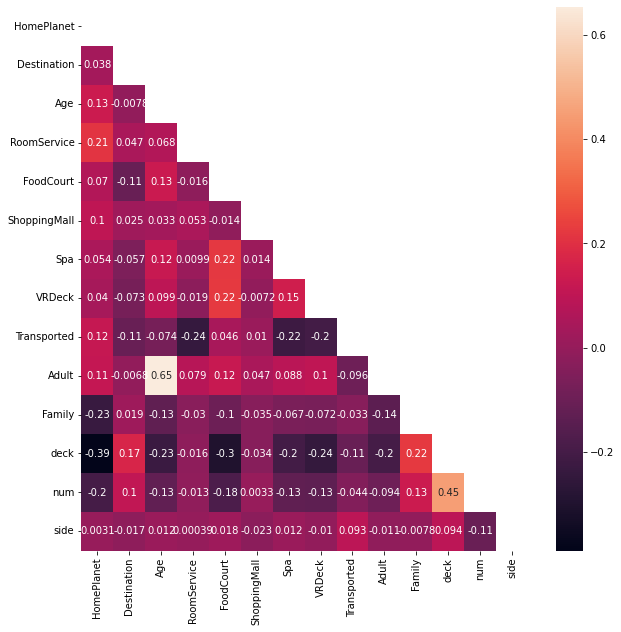

In [13]:
import seaborn as sns
corr=df.corr()
matrix=np.triu(corr)
fig, ax=plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, mask=matrix)

In [14]:
# Low feature performance: 
df=df.drop(columns=['Adult', 'Destination', "Family"], axis=1)
df.head()

,HomePlanet,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0
1,0.0,24.0,109.0,9.0,25.0,549.0,44.0,1,5.0,0.0,1.0
2,1.0,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0.0,0.0,1.0
3,1.0,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,0.0,1.0
4,0.0,16.0,303.0,70.0,151.0,565.0,2.0,1,5.0,1.0,1.0


# Split Data

In [15]:
X=df.drop('Transported', axis=1)
y=df['Transported']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13)

# XGBoost

In [16]:
import xgboost as xgb

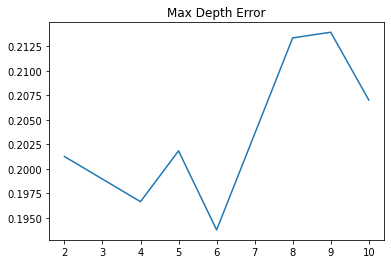

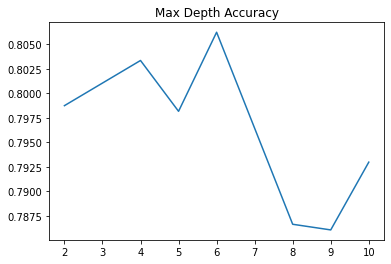

In [17]:
def maxDepth():
    numbers=[2, 4, 5, 6, 7, 8, 9, 10]
    maeList=[]
    accList=[]
    for n in numbers:
        model=xgb.XGBClassifier(max_depth=n)
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)
        
        mae=mean_absolute_error(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred)
        
        maeList.append(mae)
        accList.append(acc)
    plt.plot(numbers, maeList)
    plt.title("Max Depth Error")
    plt.show()
    
    plt.plot(numbers, accList)
    plt.title("Max Depth Accuracy")
    plt.show()
maxDepth()

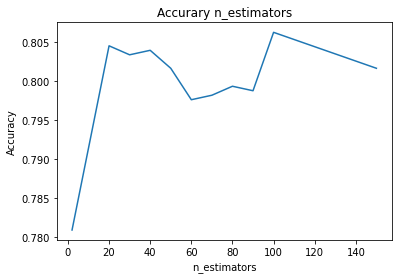

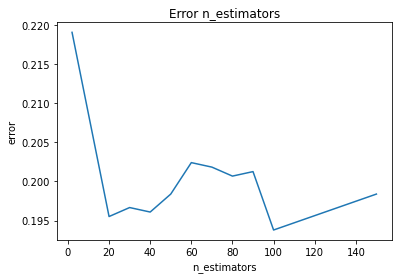

In [18]:
def estimator():
    numbers=[2, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150]
    accList=[]
    maeList=[]
    for n in numbers:
        model=xgb.XGBClassifier(n_estimators=n)
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)
        
        mae=mean_absolute_error(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred)
        accList.append(acc)
        maeList.append(mae)
    plt.plot(numbers, accList)
    plt.title("Accurary n_estimators")
    plt.ylabel("Accuracy")
    plt.xlabel("n_estimators")
    plt.show()
    
    plt.plot(numbers, maeList)
    plt.title("Error n_estimators")
    plt.ylabel("error")
    plt.xlabel("n_estimators")
    plt.show()
estimator()

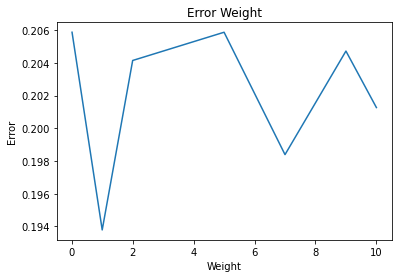

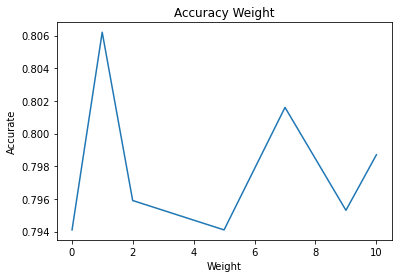

In [19]:
def childWeight():
    numbers=[0.01, 1, 2, 3, 5, 7, 9, 10]
    maeList=[]
    accList=[]

    for n in numbers:
        model = xgb.XGBClassifier(
            min_child_weight= n
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae=mean_absolute_error(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred).round(4)
        maeList.append(mae)
        accList.append(acc)
    plt.plot(numbers, maeList)
    plt.title('Error Weight')
    plt.ylabel('Error')
    plt.xlabel('Weight')
    plt.show()

    plt.plot(numbers, accList)
    plt.title('Accuracy Weight')
    plt.ylabel('Accurate')
    plt.xlabel('Weight')
    plt.show()
childWeight()

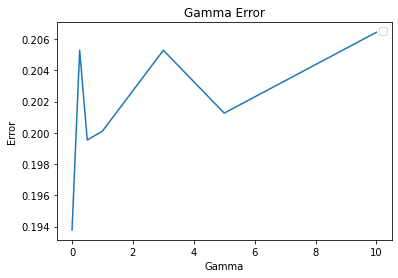

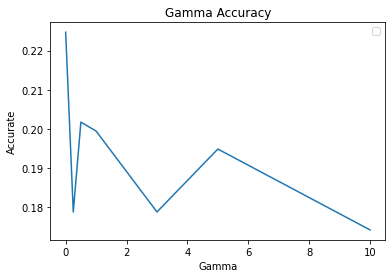

In [20]:
def gamma():
    numbers=[0, 0.25, 0.5, 1.0, 3, 5, 10]
    maeList=[]
    accList=[]

    for  n in numbers:
        regressor = xgb.XGBClassifier(
            gamma = n
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        maeList.append(xgMSE)
        accList.append(xgR2)

    plt.plot(numbers, maeList)
    plt.title('Gamma Error')
    plt.ylabel('Error')
    plt.xlabel('Gamma')
    plt.legend()
    plt.show()

    plt.plot(numbers, accList)
    plt.title('Gamma Accuracy')
    plt.ylabel('Accurate')
    plt.xlabel('Gamma')
    plt.legend()
    plt.show()
gamma()

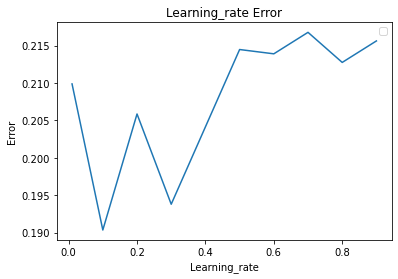

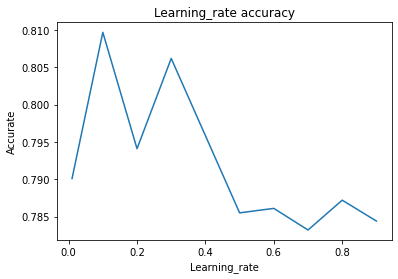

In [21]:
def learn():
    numbers = [0.01, 0.1, 0.2, 0.3, .5, .6, .7, .8, .9]
    maeList=[]
    accList=[]
    for n in numbers:
        model = xgb.XGBClassifier(
            learning_rate= n
        )
        model.fit(X_train, y_train)
        y_pred =  model.predict(X_test)

        mae=mean_absolute_error(y_test, y_pred)
        acc= accuracy_score(y_test, y_pred).round(4)
        maeList.append(mae)
        accList.append(acc)

    plt.plot(numbers, maeList)
    plt.title('Learning_rate Error')
    plt.ylabel('Error')
    plt.xlabel('Learning_rate')
    plt.legend()
    plt.show()

    plt.plot( numbers,   accList)
    plt.title('Learning_rate accuracy')
    plt.ylabel('Accurate')
    plt.xlabel('Learning_rate')
    plt.show()
learn()

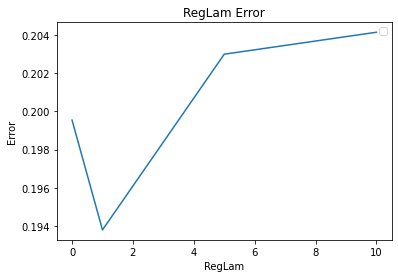

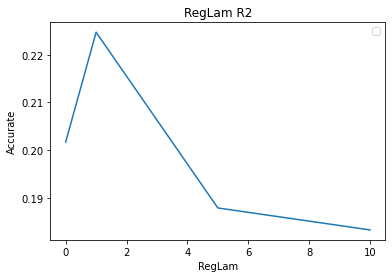

In [22]:
def regLam():
    numbers = [0, 1.0, 5.0, 10.0] #0 is default
    maeList=[]
    accList=[]

    for  n in numbers:
        regressor = xgb.XGBClassifier(
            reg_lambda= n,
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        mae=mean_absolute_error(y_test, y_pred)
        acc = r2_score(y_test, y_pred).round(4)
        maeList.append(mae)
        accList.append(acc)
    plt.plot(numbers, maeList)
    plt.title('RegLam Error')
    plt.ylabel('Error')
    plt.xlabel('RegLam')
    plt.legend()
    plt.show()

    plt.plot(numbers, accList)
    plt.title('RegLam R2')
    plt.ylabel('Accurate')
    plt.xlabel('RegLam')
    plt.legend()
    plt.show()
regLam()

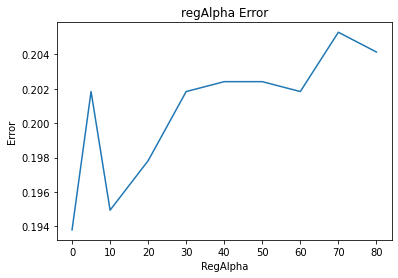

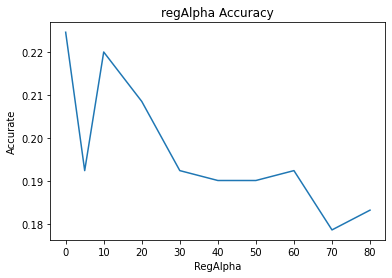

In [23]:
def regAlpha():
    numbers = [0, 5.0, 10.0, 20, 30, 40, 50, 60, 70, 80]  #0 is default
    listMSE=[]
    listR2=[]

    for n in numbers:
        regressor = xgb.XGBClassifier(
            reg_alpha=n,
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)

    plt.plot(numbers, listMSE)
    plt.title('regAlpha Error')
    plt.ylabel('Error')
    plt.xlabel('RegAlpha')
    plt.show()

    plt.plot(numbers, listR2)
    plt.title('regAlpha Accuracy')
    plt.ylabel('Accurate')
    plt.xlabel('RegAlpha')
    plt.show()
regAlpha()

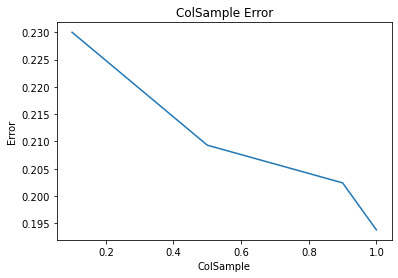

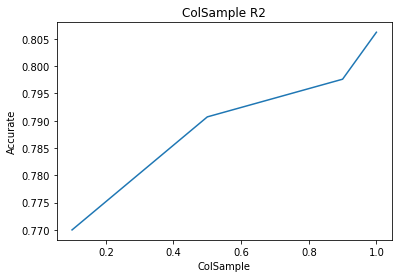

In [24]:
def colSample():
    numbers = [0.1, 0.5, 0.9, 1]
    maeList=[]
    accList=[]
    for n in numbers:
        model = xgb.XGBClassifier(
            colsample_bytree= n
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae=mean_absolute_error(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred).round(4)
        maeList.append(mae)
        accList.append(acc)

    plt.plot(numbers, maeList)
    plt.title('ColSample Error')
    plt.ylabel('Error')
    plt.xlabel('ColSample')
    plt.show()

    plt.plot(numbers, accList)
    plt.title('ColSample R2')
    plt.ylabel('Accurate')
    plt.xlabel('ColSample')
    plt.show()
colSample()

# GridSearch

In [25]:
def gridSearch():
    print("start")
    start=time.time()
    params={
        'n_estimators':[70, 100],
        'max_depth':[3, 4, 5],
        'min_child_weight': [2, 3, 4],
        'learning_rate':[.1],
        'gamma':[.01],
        'reg_alpha':[0, 1],
        'reg_lambda':[1],
        'colsample_bytree':[1]
    }
    boost_gs=xgb.XGBClassifier()
    kfold=KFold(n_splits=10, shuffle=True, random_state=42)
    boost_gs=GridSearchCV(boost_gs, param_grid=params, scoring='accuracy', cv=kfold)
    boost_gs.fit(X_train, y_train)
    print("Done. ", time.time()-start, " seconds")
    print(boost_gs.best_params_)
#gridSearch()

# XGB Final
The best models gridSearch found are: 
* CV = 10 {'colsample_bytree': 1, 'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1}
* CV 5 = {'colsample_bytree': 1, 'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 1}

In [26]:
xgbFinal=xgb.XGBClassifier(
    max_depth=4, 
    n_estimators=100, 
    min_child_weight=3,
    gamma=.01,
    reg_alpha=1,
    reg_lambda=1,
    colsample_bytree=1,
    learning_rate=.1
)
xgbFinal.fit(X_train, y_train)
y_pred=xgbFinal.predict(X_test)

xgScore=xgbFinal.score(X_test, y_test).round(4)
xgCV=cross_validate(xgbFinal, X, y, cv=10, scoring='accuracy')
xgCV=xgCV['test_score'].mean().round(4)
print(xgScore, " prediction score")
print(xgCV, " actual")
print(round(xgScore-xgCV,4), " cross validation difference")

0.7953  prediction score
0.7934  actual
0.0019  cross validation difference


# Graph

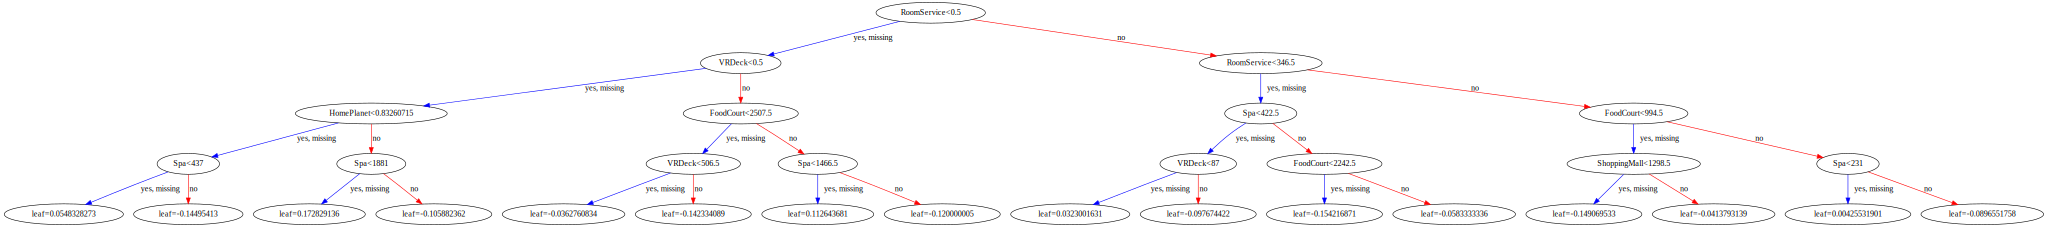

In [27]:
import graphviz
xgb.to_graphviz(xgbFinal)

# Feature Importance

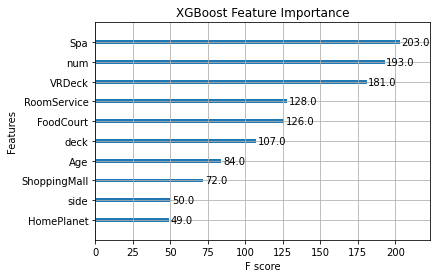

<Figure size 1440x1440 with 0 Axes>

In [28]:
xgb.plot_importance(xgbFinal, title="XGBoost Feature Importance")
plt.figure(figsize=(20, 20))
plt.show()

In [29]:
importance=xgbFinal.feature_importances_
name=xgbFinal.feature_names_in_
print("Feature Importance:")
for num in range(len(name)):
    print(importance[num], " ", name[num])

Feature Importance:
0.24835242   HomePlanet
0.01970164   Age
0.22525194   RoomService
0.05498257   FoodCourt
0.036485817   ShoppingMall
0.11801855   Spa
0.12293263   VRDeck
0.07490657   deck
0.04264669   num
0.056721143   side


# Gradient Boost
AUC for gradient boost is:  0.7922
The mean squared error (MSE) on test set: 0.2082

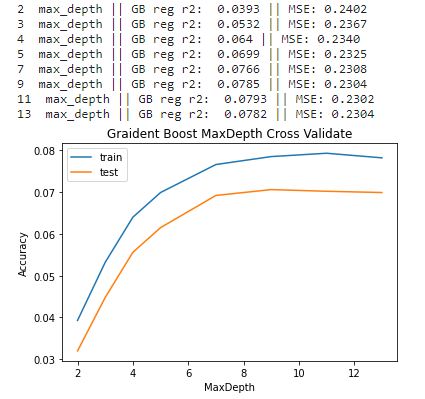
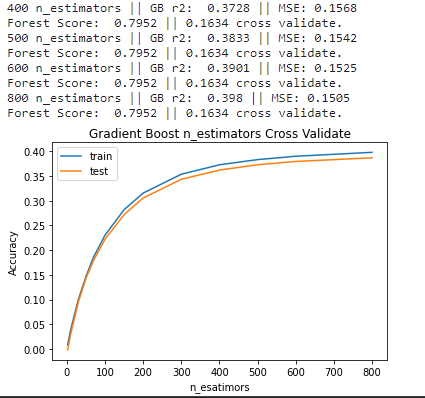

In [30]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

def gbDepth():
    depthList=[2, 3, 4, 5, 7, 9, 11, 13]
    accList=[]
    cvList=[]
    
    for d in depthList:
        params = {
         "n_estimators": 10, "max_depth": d, 
            "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        gb = ensemble.GradientBoostingRegressor(**params)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        
        gbR2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, gb.predict(X_test))
        print(d, " max_depth || GB reg r2: ", gbR2, "|| MSE: {:.4f}".format(mse)) 
        
        gbScore = gb.score(X_test, y_test).round(4)  # train test 
        gbCV = cross_validate(gb, X, y, cv = 5, scoring= 'r2')
        gbCV=gbCV['test_score'].mean().round(4)
        
        cvList.append(gbCV)
        accList.append(gbScore)
        
    plt.plot(depthList,accList, label="train")
    plt.plot(depthList,cvList, label="test")
    plt.title('Graident Boost MaxDepth Cross Validate')
    plt.xlabel('MaxDepth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 

def gbN():
    nList=[2, 10, 30, 50, 70, 100, 150, 200, 300, 400, 500, 600, 800]
    accList=[]
    cvList=[]
    for n in nList:
        params = {
         "n_estimators": n, "max_depth": 2, 
            "min_samples_split": 2, "learning_rate": 0.01,
        }

        #Fit and Predict:
        gb = ensemble.GradientBoostingRegressor(**params)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        
        gbR2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, gb.predict(X_test))
        print(n, "n_estimators || GB r2: ", gbR2, "|| MSE: {:.4f}".format(mse)) 
        
        gbScore = gb.score(X_test, y_test).round(4)  # train test 
        gbCV = cross_validate(gb, X, y, cv = 4, scoring= 'r2')
        gbCV=gbCV['test_score'].mean().round(4)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
        
        accList.append(gbScore)
        cvList.append(gbCV)
    
    plt.plot(nList,accList, label="train")
    plt.plot(nList,cvList, label="test")
    plt.title('Gradient Boost n_estimators Cross Validate')
    plt.xlabel('n_esatimors')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 
    
def gbSplit():
    sList=[2, 3, 5, 7]
    
    for s in sList:
        params = {
         "n_estimators": 500, "max_depth": 2,
            "min_samples_split": s, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4)
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(s," min_samples_splits || R2 ", gbr_r2, " || MSE {:.4f}".format(mse))

#Turn on or off functions here:
#gbDepth()
#gbN()
#gbSplit()

In [31]:
params = {
 "n_estimators": 600, 
    "max_depth": 5, 
    "min_samples_split": 7, 
    "learning_rate": 0.01,
}

#Fit and Predict:
reg = ensemble.GradientBoostingClassifier(**params)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

#AUC of model
auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for gradient boost is: ", auc)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Gradient boosting regression r2:  0.204
AUC for gradient boost is:  0.8015
The mean squared error (MSE) on test set: 0.1990


# Feature Importance

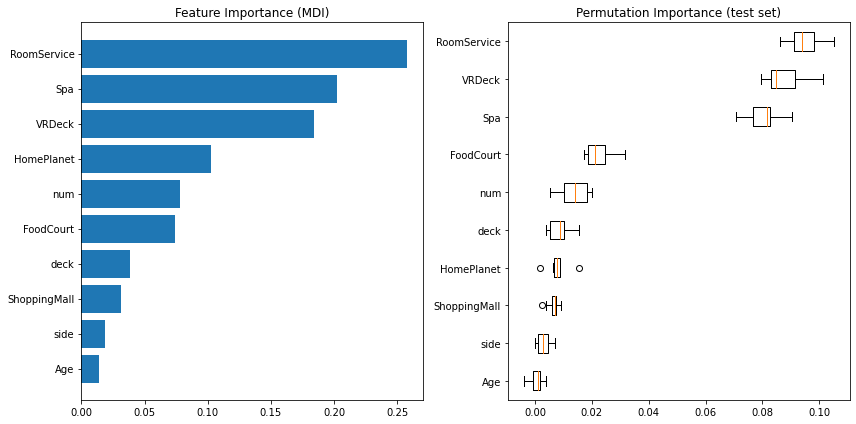

In [32]:
cols=X.columns
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(solver='liblinear') #solver param gets rid of encoder error

#Train the model and create predictions
logReg.fit(X_train, y_train)
logPredict = logReg.predict_proba(X_test)[::,1]

#calculate AUC of model
auc = round( metrics.roc_auc_score(y_test, logPredict), 4 ) 
print("AUC for logistic regression is: ", auc)

#CROSS VALIDATE TEST RESULTS:
logScore = logReg.score(X_test, y_test).round(4)  # train test 
print("Logistic Accuracy: ", logScore)
logCV = cross_validate(logReg, X, y, cv = 5, scoring= 'r2')
logCV=logCV['test_score'].mean().round(4)
print(logCV, " Logistic Regression cross validate")

AUC for logistic regression is:  0.8557
Logistic Accuracy:  0.7746
0.0949  Logistic Regression cross validate


# Decision Tree
* 11  best max_depth parameter with least MAE
* 500  best max_leaf_node

#### Overfitting Tree:
Decision tree tends to overfit data which is clearly happening in this case:

AUC for decision tree is: 0.9187
R-squared for decision tree is: 0.5415
0.3099 Tree cross validate mean
Line graphs should help show where the decision tree parameters should truly be set at. 
The train data results should correlated with the final test data.

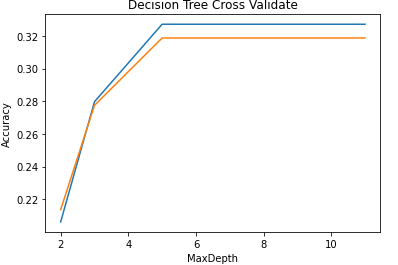

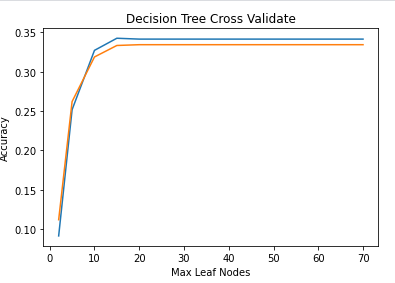

In [34]:
from sklearn.tree import DecisionTreeClassifier

#FIND best_tree_size LEAF NODES:
def calcLeaf():
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500, 700]
    maeDic={} #dictionary  key=leaf  mae=value
    for leaf in candidate_max_leaf_nodes:
        model =  DecisionTreeClassifier(max_leaf_nodes=leaf, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[leaf]=mae
    print(maeDic)
    best_tree_size = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_tree_size, " best max_leaf_node") #500 is best
    
def calcDepth():
    max_depth_list = [2, 3, 5, 7, 9, 11, 15]
    maeDic={} #dictionary  key=depth  mae=value
    for d in max_depth_list:
        model = DecisionTreeClassifier(max_leaf_nodes=500, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[d]=mae
    print(maeDic)
    best_max_depth = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_max_depth, " best max_depth parameter with least MAE") #11
    
def automateTree():
    start=time.time()
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
    max_depth_list = [2, 3, 5, 7, 9, 11]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    aucList=[]
    maeList=[]
    maxDepthList=[]
    maxLeafNodesList=[]

    for d in max_depth_list:
        for leaf in candidate_max_leaf_nodes:
            model = DecisionTreeClassifier(max_leaf_nodes=leaf, max_depth=d, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred).round(4)
            treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
            
            aucList.append(treeAUC)
            maeList.append(mae)
            maxDepthList.append(d)
            maxLeafNodesList.append(leaf)
           
            
    df = pd.DataFrame(list(zip(aucList, maeList, maxDepthList, maxLeafNodesList)),
                          columns=['AUC','MAE', 'MaxDepth', 'MaxLeafNodes'])
    
    df=df.sort_values(by=['AUC'], ascending=True)
    print("Done. ", round(time.time()-start,4), " seconds")
    return df

#calcDepth() 
#calcLeaf()
#treeDF=automateTree()
#treeDF.head()

In [35]:
def validateTreeDepth():
    max_depth_list = [2, 3, 4, 5, 7, 9, 11]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    accList=[]
    cvList=[]
    maeList=[]
    
    maxLeafNodesList=[]
    maxDepthList=[]

    for d in max_depth_list:
        maxDepthList.append(d)
        
        tree = DecisionTreeClassifier(max_leaf_nodes=10, max_depth=d, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeR2 = r2_score(y_test, y_pred).round(4)
        accList.append(treeR2)

        #CROSS VALIDATE TEST RESULTS:
        treeScore = tree.score(X_test, y_test).round(4)  # train test 
        #print("Tree Score: ", treeScore)
        treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
        treeCV=treeCV['test_score'].mean().round(4)
        cvList.append(treeCV)
        #print(treeCV, " Decision Tree cross validate.")
       # print(treeCV-treeR2, " validation error")
    plt.plot(maxDepthList,accList, label="line1")
    plt.plot(maxDepthList,cvList, label="line2")
    plt.title('Decision Tree Cross Validate')
    plt.xlabel('MaxDepth')
    plt.ylabel('Accuracy')
    plt.show() 
#validateTreeDepth()

In [36]:
def validateLeafTree():
    accList=[]
    cvList=[]
    maeList=[]
    
    maxLeafNodesList=[]
    maxDepthList=[]
    
    candidate_max_leaf_nodes = [2, 3, 4, 5, 8, 10, 15, 20]
    for leaf in candidate_max_leaf_nodes:
        maxLeafNodesList.append(leaf)
        
        tree = DecisionTreeClassifier(max_leaf_nodes=leaf, max_depth=4, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeR2 = r2_score(y_test, y_pred).round(4)
        accList.append(treeR2)

        #CROSS VALIDATE TEST RESULTS:
        treeScore = tree.score(X_test, y_test).round(4)  # train test 
        #print("Tree Score: ", treeScore)
        treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
        treeCV=treeCV['test_score'].mean().round(4)
        cvList.append(treeCV)
        #print(treeCV, " Decision Tree cross validate.")
       # print(treeCV-treeR2, " validation error")
    
    plt.plot(maxLeafNodesList,accList, label="line1")
    plt.plot(maxLeafNodesList,cvList, label="line2")
    plt.title('Decision Tree Cross Validate')
    plt.xlabel('Max Leaf Nodes')
    plt.ylabel('Accuracy')
    plt.show() 
#validateLeafTree()

#### Decision Tree Final Prediction

In [37]:
tree = DecisionTreeClassifier(
    max_leaf_nodes=10, 
    max_depth=5,
    random_state=42)

#FIT AND PREDICT:
tree.fit(X, y)
y_pred = tree.predict(X_test)

#AUC and R2 METRICS:
treeR2 = r2_score(y_test, y_pred).round(4)
treeAUC = metrics.roc_auc_score(y_test, y_pred).round(4)
print("AUC for decision tree is: ", treeAUC)
#print("R-squared for decision tree is: ", treeR2)

treeMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(round(treeMSE, 4), " is tree MSE ")

#CROSS VALIDATE RESULTS:
treeScore = tree.score(X_test, y_test).round(4)  # train test 
print("TreeScore: ", treeScore)
treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
treeCV=treeCV['test_score'].mean().round(4)
print(treeCV, " Tree cross validate mean")

AUC for decision tree is:  0.768
0.4826  is tree MSE 
TreeScore:  0.7671
0.0249  Tree cross validate mean


# Random Forest
* 2  n_estimates |  0.7964  AUC |  0.28  MAE
* 102  n_estimates |  0.8554  AUC |  0.28  MAE
* 202  n_estimates |  0.8554  AUC |  0.28  MAE
* 302  n_estimates |  0.8555  AUC |  0.28  MAE
* 402  n_estimates |  0.8558  AUC |  0.28  MAE

#### Cross Validate: <br>
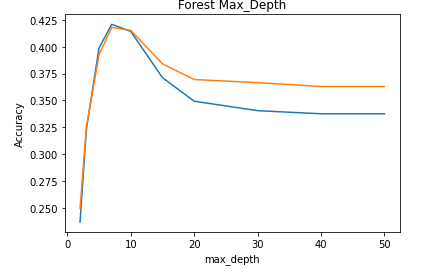
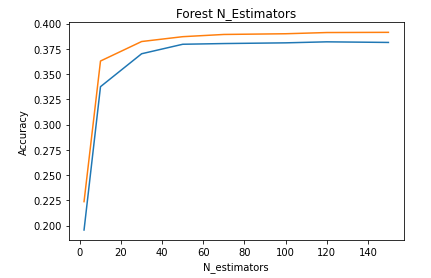

In [38]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

#Check for Error and find Best n_estimators:
def checkNumEst():
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    nEst=[] #store n_estimators
    cvList=[] #cross validate list
    accList=[] #accuracy train data
    mae=[] #error
    
    for n in [2, 10, 30, 50, 70, 100, 120, 150]:
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
      
        #CROSS VALIDATE TEST RESULTS:
        forestScore = forest.score(X_test, y_test).round(4)  # train test 
        forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
        forestCV=forestCV['test_score'].mean().round(4)
        
        print("n_estimates: ", n,  '  Mean Absolute Error:', MAE)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
       
        nEst.append(n)
        cvList.append(forestCV)
        accList.append(forestScore)
        mae.append(MAE)
        
    plt.plot(nEst,accList, label="line1")
    plt.plot(nEst,cvList, label="line2")
    plt.title("Forest N_Estimators")
    plt.xlabel('N_estimators')
    plt.ylabel('Accuracy')
    plt.show() 
    
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)
    
def fMaxDepth():
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    nEst=[] #store n_estimators
    cvList=[] #cross validate list
    accList=[] #accuracy train data
    mae=[] #error
    
    for n in [2, 3, 5, 7, 10, 15, 20, 30, 40, 50]:
        forest = RandomForestRegressor(n_estimators=10, max_depth=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
      
        #CROSS VALIDATE TEST RESULTS:
        forestScore = forest.score(X_test, y_test).round(4)  # train test 
        forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
        forestCV=forestCV['test_score'].mean().round(4)
        
        print("max_depth: ", n,  '  Mean Absolute Error:', MAE)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
       
        nEst.append(n)
        cvList.append(forestCV)
        accList.append(forestScore)
        mae.append(MAE)
        
    plt.plot(nEst,accList, label="line1")
    plt.plot(nEst,cvList, label="line2")
    plt.title("Forest Max_Depth")
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.show() 
    
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)
    
#checkNumEst() 
#fMaxDepth()

#### Forest Final Prediction

In [39]:
forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=8, 
    random_state = 0)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

#Print Metrics:
forestR2 = r2_score(y_test, y_pred).round(4)  
forestAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("Random forest AUC: ", forestAUC) 
print("Random forest r2: ", forestR2)

forestMAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
print("Random forest MAE: ", forestMAE)

#CROSS VALIDATE TEST RESULTS:
forestScore = forest.score(X_test, y_test).round(4)  # train test 
forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
forestCV=forestCV['test_score'].mean().round(4)
print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")

Random forest AUC:  0.7988
Random forest r2:  0.1925
Random forest MAE:  0.2
Forest Score:  0.7982 || 0.1574 cross validate.


# Test Data

In [40]:
testDF=pd.read_csv(test)
ID=testDF['PassengerId']

#FEATURES:
testDF['VIP']=testDF['VIP'].astype('str').replace({'False':0, 'True':1})
testDF['CryoSleep']=testDF['CryoSleep'].astype('str').replace({'False':0, 'True':1})
testDF['Adult'] = testDF['Age'].apply(lambda x: 1 if x > 19 else 0 )

#ENCODER
testDF['deck']=testDF['Cabin'].apply(lambda x: str(x).split("/")[0])
testDF['num']=testDF['Cabin'].str.extract('(\d+)').fillna(0).astype(int)
testDF['side']=testDF['Cabin'].apply(lambda x: str(x)[-1])

testDF_encode = testDF[col_names]
encoder = OrdinalEncoder()
testDF[col_names] = encoder.fit_transform(testDF_encode)

#BILLED
#testDF['billed']=testDF['RoomService']+testDF['FoodCourt']+testDF['ShoppingMall']+testDF['Spa']+testDF['VRDeck']

#Names:
testDF[['First','Last']] = testDF.Name.apply(lambda x: pd.Series(str(x).split(" ")))
testDF['Family']=testDF.groupby('Last')['Last'].transform('count')

#Match DF Features:
features=X.columns
testDF=testDF[features]

testDF=testDF.fillna(testDF.mean())
testDF.head()

,HomePlanet,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side
0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,1.0
1,0.0,19.0,0.0,9.0,0.0,2823.0,0.0,5.0,4.0,1.0
2,1.0,31.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0
3,1.0,38.0,0.0,6652.0,0.0,181.0,585.0,2.0,1.0,1.0
4,0.0,20.0,10.0,0.0,635.0,0.0,0.0,5.0,5.0,1.0


# Final Predictions

In [41]:
test_predictions = xgbFinal.predict(testDF)
tupleData = list(zip(ID, test_predictions))
output = pd.DataFrame(tupleData, columns = ['PassengerId', 'Transported'])
output['Transported']=output['Transported'].replace({0:False, 1:True})
print(output.shape)
print(output.dtypes)
output.head()

(4277, 2)
PassengerId    object
Transported      bool
dtype: object


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [42]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
